In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cross_validation, metrics
import tensorflow as tf

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# run environment

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = 0.4)
sess_config = tf.ConfigProto(gpu_options=gpu_options)

# label

In [3]:
labels = {'0':'file', '1':'network', '2':'service', '3':'database', '4':'communication', '5':'memory', '6':'driver', 
    '7':'system', '8':'application', '9':'io', '10':'others', '11':'security', '12':'disk', '13':'processor'}

fault_label = {'0':'file', '1':'network', '2':'service', '3':'database', '4':'communication', '5':'memory', '6':'driver', 
    '7':'system', '8':'application', '9':'io', '10':'others', '11':'security', '12':'disk', '13':'processor'}

# load data

In [4]:
def one_hot(y):
    y = y.reshape(len(y))
    n_values = np.max(y) + 1
    return np.eye(n_values)[np.array(y, dtype=np.int32)]  # Returns FLOATS


def load_X(X_path):
    X_list = []
    file = open(X_path, 'r')
    # Read dataset from disk, dealing with text files' syntax
    X_signal = [np.array(item, dtype=np.float32) for item in [
               line.strip().split('\t') for line in file]]
    X_list.append(X_signal)
    file.close()
    return np.transpose(np.array(X_list), (1, 2, 0))


# Load "y" (the neural network's training and testing outputs)
def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array([elem for elem in [line.strip().split('\t') for line in file]], 
                  dtype=np.int32)
    file.close()
    # Substract 1 to each output class for friendly 0-based indexing
    return one_hot(y_-1)


dataset_path = "data_msg_type/"
X_path = dataset_path + "semantic_sim.txt"
y_path = dataset_path + "semantic_label_index.txt"

X = load_X(X_path)
y = load_y(y_path)
x = X.reshape(len(X), 10, 14, 1)

# Separate our training data into test and training.
print("Separating data into 80% training set & 20% test set...")
train_x, test_x, train_y, test_y = cross_validation.train_test_split(
    x, y, test_size=0.2, random_state=33)#add random state here...
print("Dataset separated.\n")
print(train_x.shape, train_y.shape, test_y.shape)

Separating data into 80% training set & 20% test set...
Dataset separated.

((80000, 10, 14, 1), (80000, 14), (20000, 14))


# define parameters

In [5]:
learning_rate = 0.001
training_iters = 80000
test_iters = 2000000
batch_size = 100
display_step = 20000

# Network Parameters
input_height = 10
input_width = 14
num_channels = 1
n_classes = 14
dropout = 0.75 # Dropout, probability to keep units

# network config

In [9]:
# Create some wrappers for simplicity
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)


def maxpool2d(x, k=2):
    # MaxPool2D wrapper
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')


# Create model
def conv_net(x, weights, biases, dropout):
    # Reshape input picture
    x = tf.reshape(x, shape=[-1, 10, 14, 1])

    # Convolution Layer
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    # Max Pooling (down-sampling)
    conv1 = maxpool2d(conv1, k=2)
    print(conv1.shape)

    # Convolution Layer
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    # Max Pooling (down-sampling)
    conv2 = maxpool2d(conv2, k=2)
    print(conv2.shape)
    
    # Convolution Layer
    conv3 = conv2d(conv2, weights['wc3'], biases['bc3'])
    conv4 = conv2d(conv3, weights['wc4'], biases['bc4'])
    conv5 = conv2d(conv4, weights['wc5'], biases['bc5'])
    # Max Pooling (down-sampling)
    conv5 = maxpool2d(conv5, k=2)
    print(conv3.shape)
    print(conv4.shape)
    print(conv5.shape)
    
    # Convolution Layer
    conv6 = conv2d(conv5, weights['wc6'], biases['bc6'])
    conv7 = conv2d(conv6, weights['wc7'], biases['bc7'])
    conv8 = conv2d(conv7, weights['wc8'], biases['bc8'])
    # Max Pooling (down-sampling)
    conv8 = maxpool2d(conv8, k=2)
    print(conv6.shape)
    print(conv7.shape)
    print(conv8.shape)

    # Reshape conv2 output to fit fully connected layer input
    fc1 = tf.reshape(conv8, [-1, weights['wd1'].get_shape().as_list()[0]])
    
    # Fully connected layer
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, dropout)
    print(fc1.shape)
    fc2 = tf.add(tf.matmul(fc1, weights['wd2']), biases['bd2'])
    fc2 = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2, dropout)
    print(fc2.shape)
    fc3 = tf.add(tf.matmul(fc2, weights['wd3']), biases['bd3'])
    fc3 = tf.nn.relu(fc3)
    fc3 = tf.nn.dropout(fc3, dropout)
    print(fc3.shape)

    # Output, class prediction
    fc4 = tf.add(tf.matmul(fc3, weights['out']), biases['out'])
    print(fc4.shape)
    return fc4

# Store layers weight & bias
weights = {
    # 2x3 conv, 1 input, 32 outputs
    'wc1': tf.Variable(tf.random_normal([2, 3, 1, 32])),
    # 2x3 conv, 32 inputs, 64 outputs
    'wc2': tf.Variable(tf.random_normal([2, 3, 32, 64])),
    # 2x3 conv, 32 inputs, 64 outputs
    'wc3': tf.Variable(tf.random_normal([2, 3, 64, 64])),
    # 2x3 conv, 64 inputs, 32 outputs
    'wc4': tf.Variable(tf.random_normal([2, 3, 64, 32])),
    # 2x3 conv, 32 inputs, 64 outputs
    'wc5': tf.Variable(tf.random_normal([2, 3, 32, 64])),
    # 2x3 onv, 64 inputs, 32 outputs
    'wc6': tf.Variable(tf.random_normal([2, 3, 64, 32])),
    # 2x3 conv, 64 inputs, 32 outputs
    'wc7': tf.Variable(tf.random_normal([2, 3, 32, 32])),
    # 2x3 conv, 32 inputs, 32 outputs
    'wc8': tf.Variable(tf.random_normal([2, 3, 32, 32])),
    # fully connected, 2*2*32 inputs, 1024 outputs
    'wd1': tf.Variable(tf.random_normal([1*1*32, 1024])),
    # fully connected, 1024 inputs, 512 outputs
    'wd2': tf.Variable(tf.random_normal([1024, 512])),
    # fully connected, 512 inputs, 256 outputs
    'wd3': tf.Variable(tf.random_normal([512, 256])),
    # 256 inputs, 14outputs (class prediction)
    'out': tf.Variable(tf.random_normal([256, n_classes]))
}

biases = {
    'bc1': tf.Variable(tf.random_normal([32])),
    'bc2': tf.Variable(tf.random_normal([64])),
    'bc3': tf.Variable(tf.random_normal([64])),
    'bc4': tf.Variable(tf.random_normal([32])),
    'bc5': tf.Variable(tf.random_normal([64])),
    'bc6': tf.Variable(tf.random_normal([32])),
    'bc7': tf.Variable(tf.random_normal([32])),
    'bc8': tf.Variable(tf.random_normal([32])),
    'bd1': tf.Variable(tf.random_normal([1024])),
    'bd2': tf.Variable(tf.random_normal([512])),
    'bd3': tf.Variable(tf.random_normal([256])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

# build model

In [10]:
x = tf.placeholder(tf.float32, [None,input_height,input_width,num_channels])
y = tf.placeholder(tf.float32, [None, n_classes])
keep_prob = tf.placeholder(tf.float32) #dropout (keep probability)

pred = conv_net(x, weights, biases, keep_prob)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

(?, 5, 7, 32)
(?, 3, 4, 64)
(?, 3, 4, 64)
(?, 3, 4, 32)
(?, 2, 2, 64)
(?, 2, 2, 32)
(?, 2, 2, 32)
(?, 1, 1, 32)
(?, 1024)
(?, 512)
(?, 256)
(?, 14)


# train and test

In [11]:
def extract_batch_size(_train, step, batch_size):   
    # Function to fetch a "batch_size" amount of data from "(X|y)_train" data.    
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)
    for i in range(batch_size):
        # Loop index
        index = ((step-1)*batch_size + i) % len(_train)
        batch_s[i] = _train[index] 
    return batch_s


test_losses = []
test_accuracies = []
test_predictions = []
train_losses = []
train_accuracies = []


init = tf.global_variables_initializer()
with tf.Session(config=sess_config) as sess:
    sess.run(init)
    
    step = 1
    # Keep training until reach max iterations
    while step * batch_size <= training_iters:
        batch_xs = extract_batch_size(train_x, step, batch_size)
        batch_ys = extract_batch_size(train_y, step, batch_size)

        # Fit training using batch data
        _, loss, acc = sess.run([optimizer, cost, accuracy],
                       feed_dict={x: batch_xs, y: batch_ys, keep_prob: dropout})

        train_losses.append(loss)
        train_accuracies.append(acc)  
        
        
        batch_xt = extract_batch_size(test_x, step, batch_size)
        batch_yt = extract_batch_size(test_y, step, batch_size)
    
        # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
        test_predict, test_loss, test_acc = sess.run([pred, cost, accuracy], 
                                            feed_dict={x: batch_xt, y: batch_yt, keep_prob: 1.})
        
        test_predictions.append(np.argmax(test_predict, axis=1))
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)

        # Evaluate network only at some steps for faster training: 
        if (step*batch_size % display_step == 0) or (step == 1) \
            or (step * batch_size > training_iters):

            print("Training epochs #" + str(step*batch_size) + \
                  ": Batch Loss = " + "{:.6f}".format(loss) + \
                  ", Accuracy = {}".format(acc))
        
            print("Performance on test set: " + "Training epochs #" + str(step*batch_size) +\
                  ", Batch Loss = {}".format(test_loss) + ", Accuracy = {}".format(test_acc))
        step += 1

    print("Optimization Finished!")

Training epochs #100: Batch Loss = 613417746432.000000, Accuracy = 0.019999999553
Performance on test set: Training epochs #100, Batch Loss = 3.3554907136e+11, Accuracy = 0.019999999553
Training epochs #20000: Batch Loss = 1798785280.000000, Accuracy = 0.689999938011
Performance on test set: Training epochs #20000, Batch Loss = 598939712.0, Accuracy = 0.829999983311
Training epochs #40000: Batch Loss = 428199712.000000, Accuracy = 0.830000042915
Performance on test set: Training epochs #40000, Batch Loss = 107667824.0, Accuracy = 0.900000035763
Training epochs #60000: Batch Loss = 150104928.000000, Accuracy = 0.830000042915
Performance on test set: Training epochs #60000, Batch Loss = 58940128.0, Accuracy = 0.930000066757
Training epochs #80000: Batch Loss = 247114432.000000, Accuracy = 0.77999997139
Performance on test set: Training epochs #80000, Batch Loss = 82847384.0, Accuracy = 0.920000076294
Optimization Finished!


# performance visualization

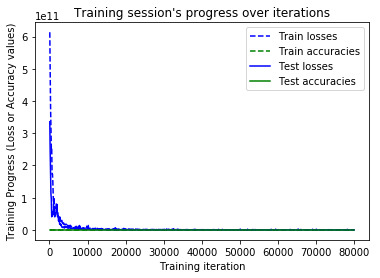

In [12]:
#font = {'family': 'Bitstream Vera Sans', 'weight': 'bold', 'size': 12}
#matplotlib.rc('font', **font)
#width = 12
#height = 12
#plt.figure(figsize=(width, height))

indep_train_axis = np.array(range(batch_size, 
                   (len(train_losses)+1)*batch_size, batch_size))
plt.plot(indep_train_axis, np.array(train_losses), "b--", label="Train losses")
plt.plot(indep_train_axis, np.array(train_accuracies), "g--", label="Train accuracies")

indep_test_axis = np.append(np.array(range(batch_size, 
                  len(test_losses)*batch_size, batch_size)), training_iters)
plt.plot(indep_test_axis, np.array(test_losses), "b-", label="Test losses")
plt.plot(indep_test_axis, np.array(test_accuracies), "g-", label="Test accuracies")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=False)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training iteration')
plt.savefig('result/lstm_loss_accuracy.png')
plt.figure()
plt.show()

Testing Accuracy: Tensor("mul:0", shape=(), dtype=float32)%

Precision: 88.9195701064%
Recall: 89.735%
f1_score: 88.5980919935%

Confusion Matrix:
[[    7    12     1     0     0     1     0     1     6     0     0     8
      0]
 [    0  1470   116     0    60    51    51    17    12     0     0    38
      0]
 [    0     3   452     0     2     1     0     0    19     0     0    29
      0]
 [    0     1     0     0     0     0     0     0     0     0     0     0
      0]
 [    0   158     1     0  2235     2    10     1     5     0     0    17
      0]
 [    0    85    56     0    29   700    76     8     2     0     0     5
      0]
 [    0     9     0     0     1     1 12419     0    12     0     0    14
      0]
 [    0   193   157     0    53   113    30    27     9     0     0    13
      0]
 [    0     3     0     0     4     0     0     0   220     0     0   195
      0]
 [    0    11     1     0     0     8     0     0     4     0     0     5
      0]
 [    0     4     1    

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


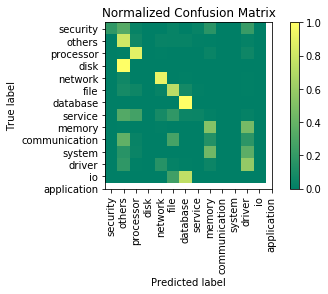

In [13]:
# Results
predictions = []
length = len(test_predictions)-200
for i in range(200):
    predictions.extend(test_predictions[length+i])

true_y = np.argmax(test_y, axis=1)

print("Testing Accuracy: {}%".format(100*accuracy))

print("")
print("Precision: {}%".format(100*metrics.precision_score(
    true_y, predictions, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(true_y, 
    predictions, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(true_y, 
    predictions, average="weighted")))

print("")
print("Confusion Matrix:")
confusion_matrix = metrics.confusion_matrix(true_y, predictions)
print(confusion_matrix)

# Plot: 
## cmap can be changed to many colors, (colormaps.Oranges,OrRd, etc)
def plot_CM(cm, title="Normalized Confusion Matrix", cmap=plt.cm.summer):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(fault_label))
    plt.xticks(tick_marks, fault_label.values(), rotation=90)
    plt.yticks(tick_marks, fault_label.values())
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()
    
print(metrics.classification_report(
    true_y, predictions, target_names = list(fault_label.values())))

cm = confusion_matrix

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:,np.newaxis]
plt.figure()
plot_CM(cm_normalized)